In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
card_df=pd.read_csv("creditcard.csv")
# print(card_df.head())
# print(card_df.info())
card_df.describe

<bound method NDFrame.describe of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
## def: Time Colums delete
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    df_copy.drop("Time", axis=1, inplace=True)
    return df_copy

In [5]:
# def: proeprocessed + train_test_split
def get_train_test_dataset(df=None):
    df_copy=get_preprocessed_df(df)
    X_features= df_copy.iloc[:, :-1]
    y_target=df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [6]:
print("학습 데이터 값 비율")
print(y_train.value_counts()/y_train.shape[0]*100)
print("테스트 데이터 값 비율")
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


# ★

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [21]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()
lr.fit(X_train, y_train)
lr_pred=lr.predict(X_test)
lr_pred_proba= lr.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8762, 재현율: 0.6216,    F1: 0.7273, AUC:0.9582


In [20]:
# from xgboost import XGBClassifier

In [23]:
def get_model_train_eval(model, feature_train =None, feature_test=None, target_train=None, target_test=None):
    model.fit(feature_train, target_train)
    pred=model.predict(feature_test)
    pred_proba=model.predict_proba(feature_test)[:,1]
    get_clf_eval(target_test, pred, pred_proba)

In [24]:
from lightgbm import LGBMClassifier

lgbm_clf= LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, feature_train =X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


<AxesSubplot:xlabel='Amount', ylabel='Density'>

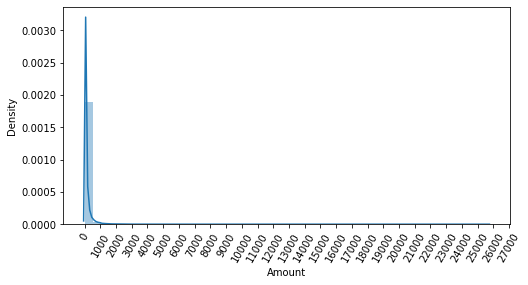

In [25]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

## 1) 정규화

In [26]:
from sklearn.preprocessing import StandardScaler

In [28]:
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, "Amount_Scaled", amount_n) #df.insert(loc, column, value, allow_duplicates=False)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [29]:
# Amount를 정규분포 형태로 변환 _____________________________________별차이없
# logistic, LightGBM  
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('===로지스틱 회귀 예측 성능 ===')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

print('=== LightGBM 예측 성능 ===')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)


===로지스틱 회귀 예측 성능 ===
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
=== LightGBM 예측 성능 ===
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


## 2) 로그

In [30]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [31]:
# logistic, LightGBM  _____________________________________  두 모델 모두 전체적으로 조금씩 개선 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('===로지스틱 회귀 예측 성능 ===')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

print('=== LightGBM 예측 성능 ===')
get_model_train_eval(lgbm_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)


===로지스틱 회귀 예측 성능 ===
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
=== LightGBM 예측 성능 ===
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


## 로그화 + 이상치 데이터 제거

<AxesSubplot:>

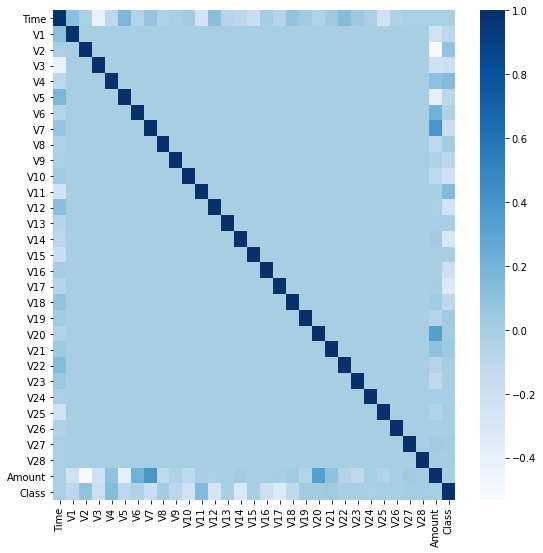

In [33]:
import seaborn as sns
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap="Blues")

In [36]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    q1 = np.percentile(fraud.values, 25)
    q3 = np.percentile(fraud.values, 75)
    iqr = q3 - q1
    iqr_weight = iqr * weight
    lowest_val = q1 - iqr_weight
    highest_val = q3 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index
    

In [37]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [38]:
# get_processed_df 로그화
#V14  이상값 삭제 ____________________ 5~6% (0.05~0.06)정도씩 오름
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, feature_train=X_train, feature_test=X_test, target_train=y_train, target_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780
